## Kitti Data


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("klemenko/kitti-dataset")

print("Path to dataset files:", path)

  8%|▊         | 1.73G/22.5G [00:25<05:10, 71.8MB/s]


KeyboardInterrupt: 

In [ ]:
import os
label_dir = os.path.join(path, "data_object_label_2/training/label_2")
image_dir = os.path.join(path, "data_object_image_2/training/image_2")
right_img_dir = os.path.join(path, "data_object_image_3/training/image_3")
calib_dir = os.path.join(path, "data_object_calib/training/calib")


NameError: name 'path' is not defined

## Label Parsing

In [ ]:
import pandas as pd
import numpy as np

labels = []
for fname in sorted(os.listdir(label_dir))[:500]:
    with open(os.path.join(label_dir, fname), 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 15:
                continue
            labels.append({
                "file": fname.replace(".txt", ".png"),
                "class": parts[0],
                "trunc": float(parts[1]),
                "occl": int(parts[2]),
                "alpha": float(parts[3]),
                "x1": float(parts[4]),
                "y1": float(parts[5]),
                "x2": float(parts[6]),
                "y2": float(parts[7]),
                "h": float(parts[8]),
                "w": float(parts[9]),
                "l": float(parts[10]),
                "x": float(parts[11]),
                "y": float(parts[12]),
                "z": float(parts[13]),
                "ry": float(parts[14])
            })

df = pd.DataFrame(labels)
df = df[df["class"] != "DontCare"].copy()



## Visualizations

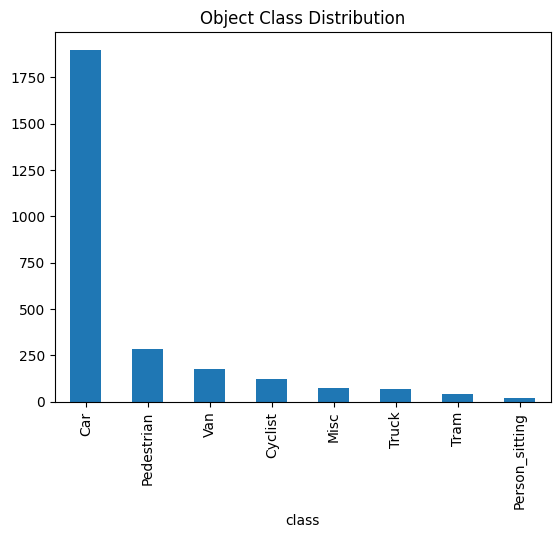

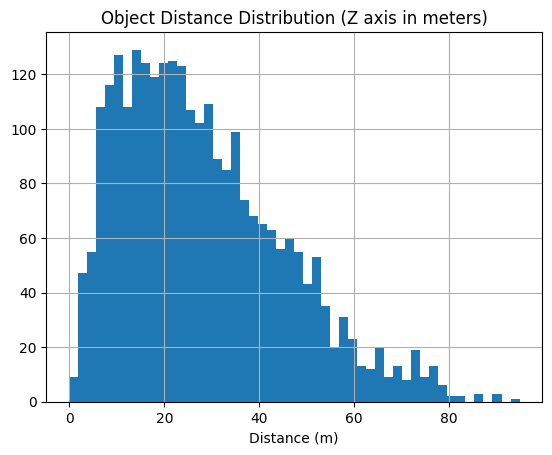

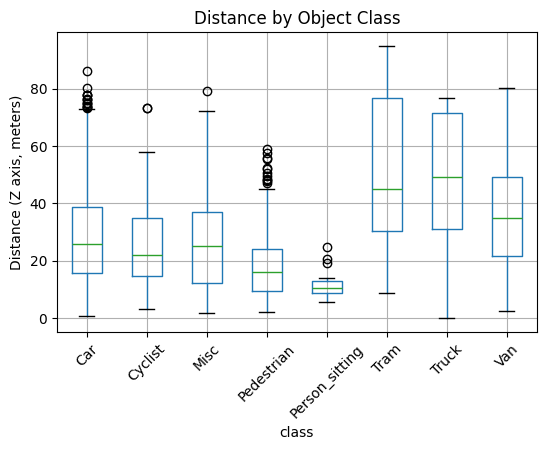

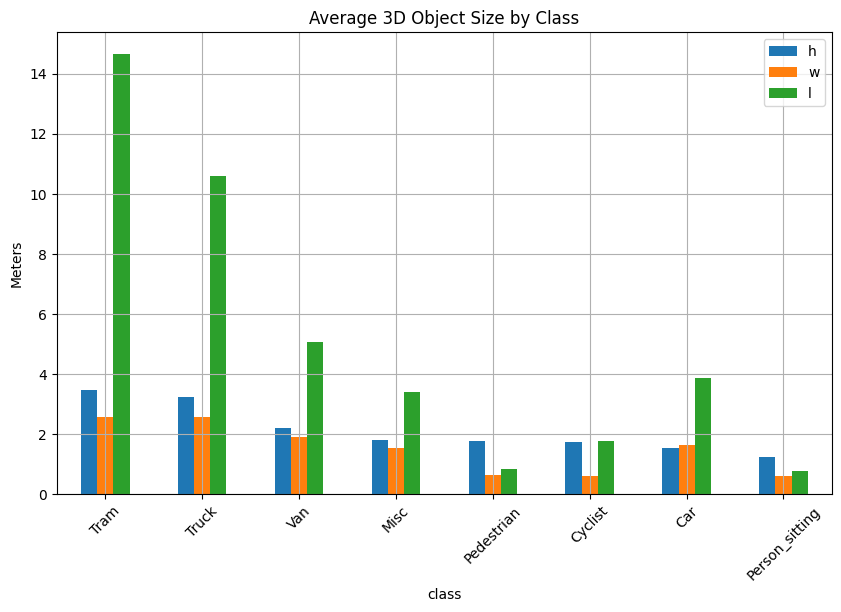

In [ ]:
import matplotlib.pyplot as plt

df["class"].value_counts().plot(kind="bar", title="Object Class Distribution")
plt.show()

df["z"].hist(bins=50)
plt.title("Object Distance Distribution (Z axis in meters)")
plt.xlabel("Distance (m)")
plt.show()

df.boxplot(column="z", by="class", figsize=(6, 4))
plt.title("Distance by Object Class")
plt.suptitle("")
plt.ylabel("Distance (Z axis, meters)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

grouped = df.groupby("class")[["h", "w", "l"]].mean().sort_values("h", ascending=False)
grouped.plot(kind="bar", figsize=(10, 6))
plt.title("Average 3D Object Size by Class")
plt.ylabel("Meters")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Drawing BBoxes


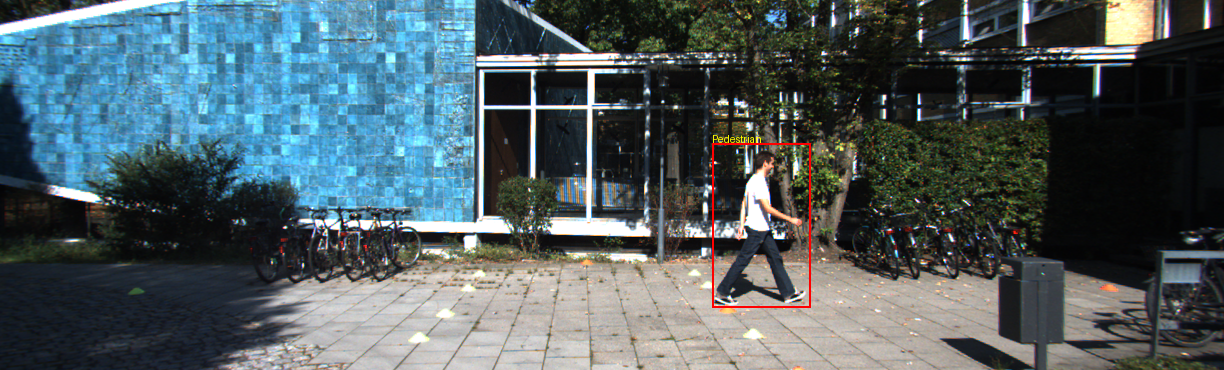

In [ ]:
from PIL import Image, ImageDraw

def draw_bboxes(image_path, df_image):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    for _, row in df_image.iterrows():
        draw.rectangle([row['x1'], row['y1'], row['x2'], row['y2']], outline="red", width=2)
        draw.text((row['x1'], row['y1'] - 10), row['class'], fill="yellow")
    return image

example_file = df.iloc[0]["file"]
df_example = df[df["file"] == example_file]
image_path = os.path.join(image_dir, example_file)
draw_bboxes(image_path, df_example)


## Calibration Loader

In [ ]:
import numpy as np

def load_calib_P2_baseline(calib_file):
    with open(calib_file, "r") as f:
        lines = f.readlines()
    P2 = np.array([float(x) for x in next(l for l in lines if l.startswith("P2")).split()[1:]]).reshape(3, 4)
    P3 = np.array([float(x) for x in next(l for l in lines if l.startswith("P3")).split()[1:]]).reshape(3, 4)
    fx = P2[0, 0]
    baseline = abs((P2[0, 3] - P3[0, 3]) / fx)
    return fx, baseline


## Depth Label Generator

In [ ]:
import cv2
from tqdm import tqdm

def generate_depth_labels_batch(n_images=2000):
    depth_labels = {}
    stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)

    for i in tqdm(range(n_images)):
        fname = f"{i:06d}.png"
        left_path = os.path.join(image_dir, fname)
        right_path = os.path.join(right_img_dir, fname)
        calib_path = os.path.join(calib_dir, fname.replace(".png", ".txt"))

        if not os.path.exists(left_path) or not os.path.exists(right_path) or not os.path.exists(calib_path):
            continue

        imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
        imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
        if imgL is None or imgR is None:
            continue

        disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
        disparity[disparity <= 0.1] = 0.1

        fx, baseline = load_calib_P2_baseline(calib_path)
        depth_map = (fx * baseline) / disparity
        depth_map = np.clip(depth_map, 0, 80)

        h, w = depth_map.shape
        center_crop = depth_map[h//3:h*2//3, w//3:w*2//3]
        median_depth = np.median(center_crop)

        depth_labels[fname] = median_depth

    return depth_labels

depth_labels = generate_depth_labels_batch(n_images=1000)
print(f"Generated depth labels for {len(depth_labels)} images.")


100%|██████████| 1000/1000 [00:49<00:00, 20.36it/s]

Generated depth labels for 1000 images.


## Dataset & DataLoaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

class KITTIDepthDataset(Dataset):
    def __init__(self, image_dir, label_dict, transform=None):
        self.image_dir = image_dir
        self.label_dict = label_dict
        self.files = list(label_dict.keys())
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Use log(1 + x) for target
        depth = self.label_dict[fname]
        label = torch.tensor(np.log1p(depth), dtype=torch.float32)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



train_files, val_files = train_test_split(list(depth_labels.keys()), test_size=0.2, random_state=42)
train_labels = {k: depth_labels[k] for k in train_files}
val_labels = {k: depth_labels[k] for k in val_files}

train_dataset = KITTIDepthDataset(image_dir, train_labels, transform)
val_dataset = KITTIDepthDataset(image_dir, val_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


## Model Definition

In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNetDistanceRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1)

    def forward(self, x):
        return self.backbone(x).squeeze(1)


## Training & Evaluation Functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetDistanceRegressor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for imgs, targets in dataloader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    predictions, truths = [], []

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            truths.extend(targets.cpu().numpy())

    # Clip log-space values before inverting
    predictions = np.clip(predictions, 0, 5)  # log1p(80) ≈ 4.4
    truths = np.clip(truths, 0, 5)

    # Convert log1p(x) → x
    preds_exp = np.expm1(predictions)
    trues_exp = np.expm1(truths)

    return total_loss / len(dataloader), preds_exp, trues_exp



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [ ]:
num_epochs = 50
best_val_loss = float("inf")
patience = 3
patience_counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, preds, trues = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()


Epoch 1/50 - Train Loss: 2.520, Val Loss: 0.062
Epoch 2/50 - Train Loss: 0.048, Val Loss: 0.047
Epoch 3/50 - Train Loss: 0.033, Val Loss: 0.039
Epoch 4/50 - Train Loss: 0.022, Val Loss: 0.040
Epoch 5/50 - Train Loss: 0.021, Val Loss: 0.037
Epoch 6/50 - Train Loss: 0.012, Val Loss: 0.032
Epoch 7/50 - Train Loss: 0.012, Val Loss: 0.032
Epoch 8/50 - Train Loss: 0.010, Val Loss: 0.030
Epoch 9/50 - Train Loss: 0.011, Val Loss: 0.031
Epoch 10/50 - Train Loss: 0.009, Val Loss: 0.029
Epoch 11/50 - Train Loss: 0.007, Val Loss: 0.028
Epoch 12/50 - Train Loss: 0.006, Val Loss: 0.027
Epoch 13/50 - Train Loss: 0.007, Val Loss: 0.029
Epoch 14/50 - Train Loss: 0.007, Val Loss: 0.030
Epoch 15/50 - Train Loss: 0.005, Val Loss: 0.029
Early stopping triggered.


## Evaluation

In [ ]:
model = ResNetDistanceRegressor()
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
model.to(device)



ResNetDistanceRegressor(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

val_loss, preds, trues = evaluate(model, val_loader, criterion)

rmse = mean_squared_error(trues, preds) ** 0.5
mae = mean_absolute_error(trues, preds)
r2 = r2_score(trues, preds)

print(f"Validation RMSE: {rmse:.2f} m")
print(f"Validation MAE: {mae:.2f} m")
print(f"Validation R²: {r2:.3f}")


Validation RMSE: 8.58 m
Validation MAE: 6.21 m
Validation R²: 0.838


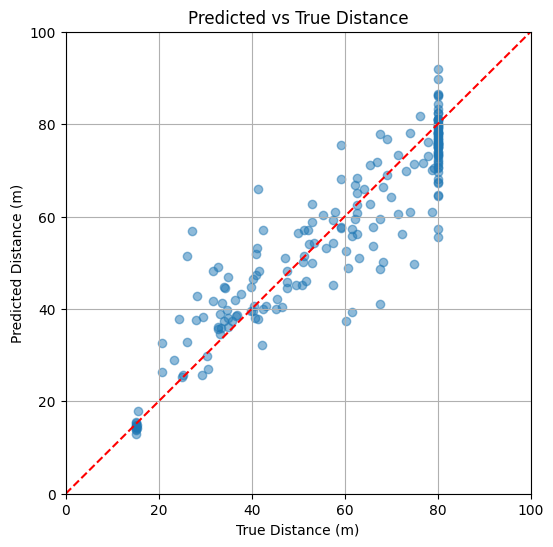

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(trues, preds, alpha=0.5)
plt.xlabel("True Distance (m)")
plt.ylabel("Predicted Distance (m)")
plt.title("Predicted vs True Distance")
plt.grid(True)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()



<ipython-input-38-61c1e5ae3fc2>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_mae = df_eval.groupby("bucket")["error"].mean()


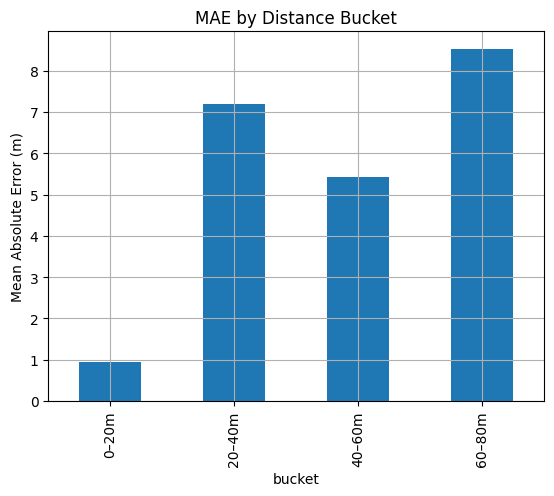

In [ ]:
df_eval = pd.DataFrame({
    "true": trues,
    "pred": preds,
    "error": np.abs(trues - preds)
})

bins = [0, 20, 40, 60, 80]
labels = ["0–20m", "20–40m", "40–60m", "60–80m"]
df_eval["bucket"] = pd.cut(df_eval["true"], bins=bins, labels=labels, right=False)

bucket_mae = df_eval.groupby("bucket")["error"].mean()

bucket_mae.plot(kind="bar", title="MAE by Distance Bucket", ylabel="Mean Absolute Error (m)")
plt.grid(True)
plt.show()


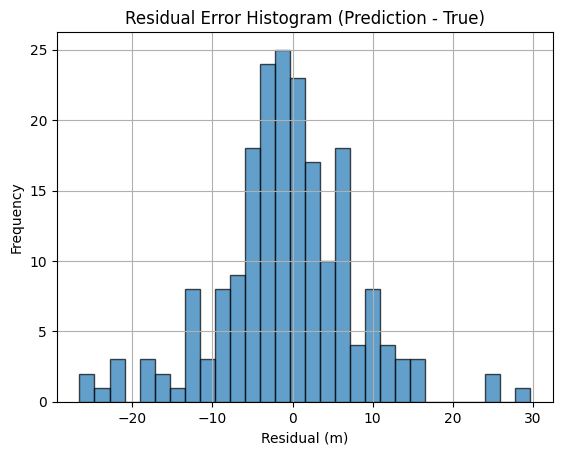

In [ ]:
residuals = preds - trues

plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title("Residual Error Histogram (Prediction - True)")
plt.xlabel("Residual (m)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
